In [4]:
import sys
sys.path.append('/opt/conda/pkgs')
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4262b1bf4bf1ffb403c0eb7a42ad5906_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4506eccf78279d93d0e8a34c035e91c5_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/6bda807e3967eae797c7b1b9eeaee8db_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c2a47d89d1d34e789fdf782557bb7194_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c6c5514ada15b890fb27d1e36371554c_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/d964a294c2d0fef56a434c021026281e_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/e1c932db5cd4271709e54d8028824bc9_/lib/python3.12/site-packages")
import pickle, os, gzip, json, sys, itertools
from pathlib import Path
from importlib import reload
from dataclasses import dataclass, field
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pysam
import scipy as sp
import seaborn
import sharedmem

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 300


sys.path.append("scripts")
sys.path.append("../../scripts")



In [5]:
from data_io import is_fwd_id, get_fwd_id, get_sibling_id
from dim_reduction import SpectralEmbedding, scBiMapEmbedding
from nearest_neighbors import (
    ExactNearestNeighbors,
    NNDescent,
    WeightedLowHash,
    PAFNearestNeighbors,
    LowHash,
    HNSW,
    ProductQuantization,
    _NearestNeighbors,
    IVFProductQuantization,
)
from graph import OverlapGraph, GenomicInterval, get_overlap_statistics, remove_false_edges
from truth import get_overlaps
from evaluate import NearestNeighborsConfig, mp_compute_nearest_neighbors
from plots import plot_read_graph, mp_plot_read_graphs, get_graphviz_layout, get_umap_layout

## Parameters


In [6]:
MAX_SAMPLE_SIZE = int(1e9)
COVERAGE_DEPTH = 20
max_bucket_size = COVERAGE_DEPTH * 1.5

## Load data

In [7]:

npz_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/HLA/pbsim_ONT_93_30k/kmer_k16/feature_matrix.npz"
tsv_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/HLA/pbsim_ONT_93_30k/kmer_k16/metadata.tsv.gz"
json_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/HLA/pbsim_ONT_93_30k/kmer_k16/read_features.json.gz"
paf_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/minimap2/CHM13/HLA/pbsim_ONT_93_30k/alignment.paf.gz"
nbr_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/Ecoli/all/ONT/kmer_k16/WeightedLowHash_Jaccard_None_TF-IDF_nbr_matrix.npz"
output_folder = "/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/CHM13/HLA/pbsim_ONT_93_30k/kmer_k16/"

threads  = 8


In [8]:
meta_df = pd.read_table(tsv_path).iloc[:MAX_SAMPLE_SIZE, :].reset_index()
read_indices = {read_name: read_id for read_id, read_name in meta_df['read_name'].items()}

feature_matrix = sp.sparse.load_npz(npz_path)[meta_df.index, :]

with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}

feature_weights = {i: 1 for i in range(feature_matrix.shape[1])}

kw = dict(data=feature_matrix)
max_bucket_size = COVERAGE_DEPTH * 1.5

In [15]:
print(len(read_features[0]))
print(len(set(read_features[0])))

882
869


In [40]:
def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)
reference_graph = OverlapGraph.from_intervals(read_intervals)

In [8]:
%%time
reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

CPU times: user 14 s, sys: 44.7 ms, total: 14.1 s
Wall time: 14.1 s


(7448, 150966, 14394, 2)

## Get nearest neighbours

In [25]:
dim_copy = dim_redu_matrix.copy()
m = 8
nbits=8
seed=455390
feature_indices = np.random.default_rng(seed).choice(
                500, 496, replace=False, shuffle=False
            )
m_496d = dim_copy[:,feature_indices]
m_496d =m_496d.astype('float32')
Specifying order='C' 
m_496d = np.array(m_496d,order='C').astype('float32')



In [10]:
with open('/home/miaocj/docker_dir/kNN-overlap-finder/workflow/notebooks/config_dict.pkl', 'rb') as file:  
    config_dict = pickle.load(file)  

In [12]:
config = config_dict['NNDescent_Euclidean_Spectural_500d_TF-IDF']
config

KeyError: 'NNDescent_Euclidean_Spectural_500d_TF-IDF'

In [41]:
config= NearestNeighborsConfig(
            nearest_neighbors_method=HNSW,
            description='HNSW,Cosine,scBiMapEmbedding,500,None',
            tfidf='None',
            dimension_reduction_method=scBiMapEmbedding,
            dimension_reduction_kw=dict(n_dimensions=500),
            nearest_neighbors_kw=dict(metric='cosine'))
configs = [config]
print(config)

NearestNeighborsConfig(description='HNSW,Cosine,scBiMapEmbedding,500,None', tfidf='None', dimension_reduction_method=<class 'dim_reduction.scBiMapEmbedding'>, nearest_neighbors_method=<class 'nearest_neighbors.HNSW'>)


In [42]:
%%time
#configs = configs[:1]
configs = [config]
max_n_neighbors = COVERAGE_DEPTH
processes = threads

nbr_dict, time_dict, memory_dict = mp_compute_nearest_neighbors(
    data=feature_matrix,
    configs=configs,
    n_neighbors=max_n_neighbors,
    processes=processes,
)

Evaluating 1 configs using 8 processes.
0 Dimension reduction.
Nearest neighbors.
Finished NearestNeighborsConfig(description='HNSW,Cosine,scBiMapEmbedding,500,None', tfidf='None', dimension_reduction_method=<class 'dim_reduction.scBiMapEmbedding'>, nearest_neighbors_method=<class 'nearest_neighbors.HNSW'>). Elapsed time: {'dimension_reduction': 141.84203171730042, 'nearest_neighbors': 0.16262173652648926}. Peak memory: {}

CPU times: user 363 ms, sys: 118 ms, total: 481 ms
Wall time: 2min 22s


In [46]:
time_dict

{0: {'dimension_reduction': 141.84203171730042,
  'nearest_neighbors': 0.16262173652648926}}

In [48]:
if complete_name[0] == 'ExactNearestNeighbors':
            config = f'''NearestNeighborsConfig(
            nearest_neighbors_method={complete_name[0]},
            description="{des}",
            binarize=True,
            tfidf=True,
            dimension_reduction_method={complete_name[2]},
            dimension_reduction_kw=dict(n_dimensions={int(complete_name[3])}),
            nearest_neighbors_kw=dict(metric={complete_name[1]}),
            **kw)'''
        print(config)
    
mypq = ProductQuantization()
nbr_indices = mypq.get_neighbors(dim_redu_matrix,n_neighbors=20,metric="cosine")

WARNING clustering 7448 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7448 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7448 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7448 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7448 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7448 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7448 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 7448 points to 256 centroids: please provide at least 9984 training points


## Statistics

In [43]:
read_ids = np.array(list(read_features))
graphs = collections.defaultdict(dict)
k_values = np.arange(2, max_n_neighbors + 1)

nbr_indices = nbr_dict[0]
for k in k_values:
    graph = OverlapGraph.from_neighbor_indices(
        neighbor_indices=nbr_indices,
        n_neighbors=k,
        read_ids=read_ids,
        require_mutual_neighbors=False,
    )
    graphs[k] = graph

In [70]:
tm = {}
tm['0'] = graphs
graphs

defaultdict(dict,
            {2: <graph.OverlapGraph at 0x7f7b8aef0f80>,
             3: <graph.OverlapGraph at 0x7f7b8aef17c0>,
             4: <graph.OverlapGraph at 0x7f7b8abc5d30>,
             5: <graph.OverlapGraph at 0x7f7b8aebe840>,
             6: <graph.OverlapGraph at 0x7f7b8aebc470>,
             7: <graph.OverlapGraph at 0x7f7b8aebc0e0>,
             8: <graph.OverlapGraph at 0x7f7b8aebeba0>,
             9: <graph.OverlapGraph at 0x7f7b8aebc2f0>,
             10: <graph.OverlapGraph at 0x7f7b8ac72900>,
             11: <graph.OverlapGraph at 0x7f7b8ac728a0>,
             12: <graph.OverlapGraph at 0x7f7b8ac70290>,
             13: <graph.OverlapGraph at 0x7f7b8ac72ea0>,
             14: <graph.OverlapGraph at 0x7f7b8ac70440>,
             15: <graph.OverlapGraph at 0x7f7b8ac71e80>,
             16: <graph.OverlapGraph at 0x7f7b8ac722d0>,
             17: <graph.OverlapGraph at 0x7f7b8aab46e0>,
             18: <graph.OverlapGraph at 0x7f7b8ac70fb0>,
             19: <gra

In [47]:
df_rows = []

for k in k_values:
    graph = graphs[k]
    graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
    time_stats = {"elapsed_time:" + k: v for k, v in time_dict.items()}
    stats = {"description": config.description, "n_neighbors": k, 
                **graph_stats, **time_stats}
    df_rows.append(stats)
df = pd.DataFrame(df_rows)
df['connected_fraction'] = 1 - df['singleton_fraction']



## Graph visualisation

In [90]:
def remove_small_components(graph, min_component_size=10):
    small_components = set()
    for component in nx.connected_components(graph):
        if len(component) < min_component_size:
            small_components |= component
    graph.remove_nodes_from(small_components)
            
    
def plot_graphs(graphs, reference_graph, metadata, *, min_component_size=10, 
                processes=8, layout_method='stdp', figsize=(6, 6), node_size=3,
    seed: int = 4829, verbose=True):
    axes = []
    new_graphs = []
    g = graphs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    ax1.set_title("All edges")
    ax2.set_title("Correct edges")
    
    g = g.copy()
    remove_small_components(g, min_component_size=min_component_size)
    new_graphs.append(g)
    axes.append(ax1)
 
    g = g.copy()
    remove_false_edges(g, reference_graph)
    remove_small_components(g, min_component_size=min_component_size)
    new_graphs.append(g)
    axes.append(ax2)

    fig.suptitle('method', ha="center", va="bottom", wrap=True, size=7)

    query_graphs = new_graphs
    def plot(i, pos):
        plot_read_graph(
            ax=axes[i],
            query_graph=query_graphs[i],
            reference_graph=reference_graph,
            metadata=metadata,
            pos=pos,
            node_size=node_size,
        )

    with sharedmem.MapReduce(np=processes) as pool:

        def work(i):
            if layout_method == "umap":
                pos = get_umap_layout(graph=query_graphs[i])
            else:
                pos = get_graphviz_layout(
                    graph=query_graphs[i],
                    figsize=figsize,
                    seed=seed,
                    layout_method=layout_method,
                ) 
            return i, pos

        def reduce(i, pos):
            if verbose:
                print(i, end=" ")
            plot(i, pos)

        pool.map(work, range(len(query_graphs)), reduce=reduce)
        if verbose:
            print("")

    return fig

1 0 


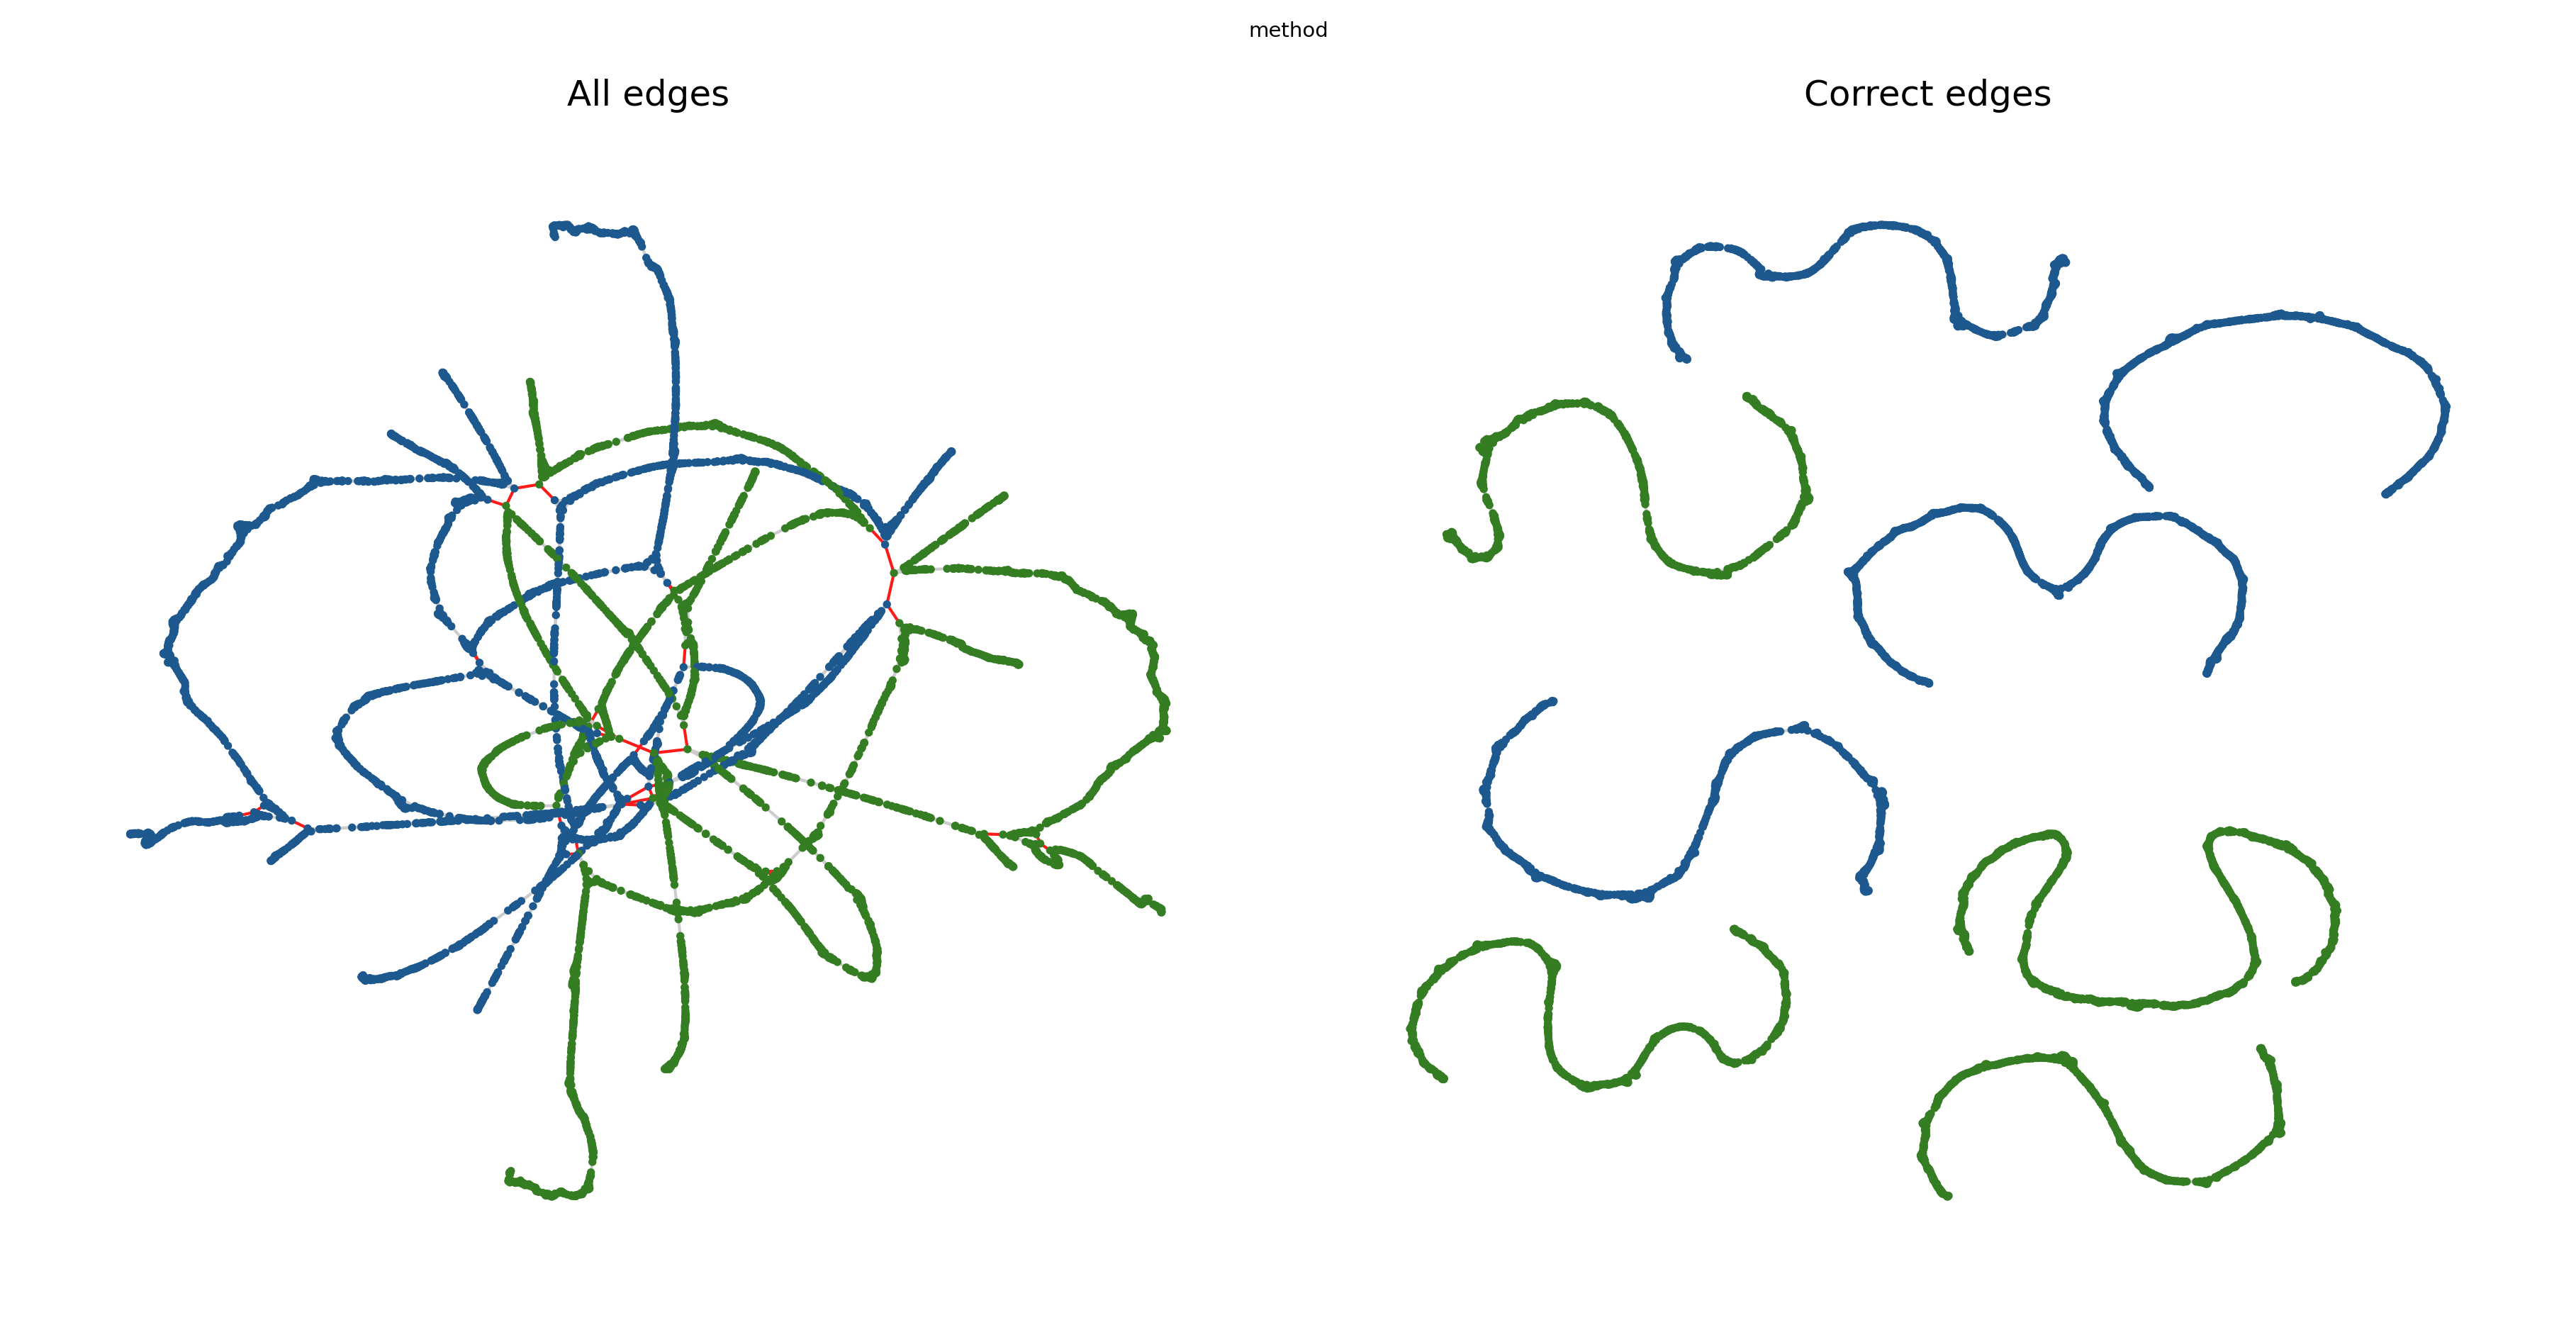

In [91]:
import pygraphviz
k6_graphs = graphs[6]
figures = plot_graphs(
    k6_graphs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp", processes=threads
)

In [77]:
figures[0].savefig('/home/miaocj/docker_dir/kNN-overlap-finder/test.png', bbox_inches='tight',dpi=300)

In [ ]:
%%time
k12_graphs = [graphs[i][6] for i in range(len(graphs))]
plot_graphs(
    k12_graphs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp", processes=threads
)